#MultiClass Emotion Recognition Using Fer-2013 Dataset

In [ ]:
%cd /content/drive/MyDrive/senior-project/CNNs/

/content/drive/MyDrive/senior-project/CNNs


In [ ]:
!pip install utils
!pip install livelossplot

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

###Load Data

In [ ]:
data = pd.read_csv('fer2013.csv')

###Scale Data

In [ ]:
for i in range(len(data)):
  data['pixels'][i] = data['pixels'][i].split(" ")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
for i in range(len(data)):
  data['pixels'][i] = [int(x) / 255 for x in data['pixels'][i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
for i in range(len(data)):
  data['pixels'][i] = " ".join(str(item) for item in data['pixels'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


###Data Processing

In [ ]:
train_data = data[data.Usage == "Training"]

In [ ]:
train_pixels = train_data.pixels.str.split(" ").tolist()
train_pixels = pd.DataFrame(train_pixels , dtype=int)
train_images = train_pixels.values
train_images = train_images.astype(np.float)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3552: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [ ]:
train_labels_flat = train_data["emotion"].values.ravel()
train_labels_count = np.unique(train_labels_flat).shape[0]

In [ ]:
def dense_to_one_hot(labels_dense, num_classes):
  num_labels = labels_dense.shape[0]
  
  index_offset = np.arange(num_labels) * num_classes
  labels_one_hot = np.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot

In [ ]:
y_train = dense_to_one_hot(train_labels_flat, train_labels_count)
y_train = y_train.astype(np.uint8)

In [ ]:
test_data = data[data.Usage == "PublicTest"]
test_pixels = test_data.pixels.str.split(" ").tolist()

test_pixels = pd.DataFrame(test_pixels, dtype=int)
test_images = test_pixels.values
test_images = test_images.astype(np.float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
test_labels_flat = test_data["emotion"].values.ravel()
test_labels_count = np.unique(test_labels_flat).shape[0]

y_test = dense_to_one_hot(test_labels_flat,test_labels_count)
y_test = y_test.astype(np.uint8)

In [ ]:
x_train = train_images.reshape(-1, 48, 48, 1)
x_test = test_images.reshape(-1,48,48,1)

###Model Building

In [ ]:
model = Sequential()

model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',
                            save_weights_only=True, mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss' , factor=0.1, patience=2, min_lr=0.00001,model='auto')

callbacks = [PlotLossesKeras(), checkpoint, reduce_lr]

r = model.fit( x_train, y_train,  
                        epochs=20,
                        shuffle=True,
                        batch_size=200,
                        validation_data=(x_test, y_test),
                                              verbose=2)

Epoch 1/20
144/144 - 38s - loss: 1.8819 - accuracy: 0.2776 - val_loss: 1.9165 - val_accuracy: 0.1819 - 38s/epoch - 263ms/step
Epoch 2/20
144/144 - 20s - loss: 1.5699 - accuracy: 0.4054 - val_loss: 1.9452 - val_accuracy: 0.1845 - 20s/epoch - 136ms/step
Epoch 3/20
144/144 - 20s - loss: 1.3983 - accuracy: 0.4678 - val_loss: 1.7879 - val_accuracy: 0.3664 - 20s/epoch - 138ms/step
Epoch 4/20
144/144 - 19s - loss: 1.3034 - accuracy: 0.5009 - val_loss: 1.3616 - val_accuracy: 0.4798 - 19s/epoch - 134ms/step
Epoch 5/20
144/144 - 19s - loss: 1.2282 - accuracy: 0.5359 - val_loss: 1.3389 - val_accuracy: 0.4628 - 19s/epoch - 133ms/step
Epoch 6/20
144/144 - 19s - loss: 1.1685 - accuracy: 0.5556 - val_loss: 1.3764 - val_accuracy: 0.4907 - 19s/epoch - 134ms/step
Epoch 7/20
144/144 - 19s - loss: 1.1214 - accuracy: 0.5756 - val_loss: 1.3558 - val_accuracy: 0.4840 - 19s/epoch - 135ms/step
Epoch 8/20
144/144 - 19s - loss: 1.0782 - accuracy: 0.5917 - val_loss: 1.2581 - val_accuracy: 0.5208 - 19s/epoch - 135

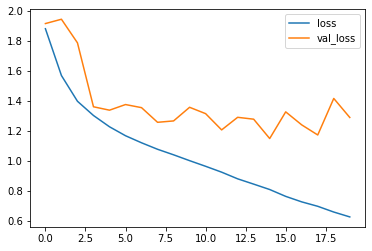

In [ ]:
plt.plot(r.history['loss'],label = 'loss')
plt.plot(r.history['val_loss'],label ='val_loss')
plt.legend()

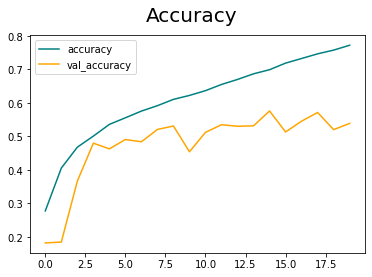

In [ ]:
fig = plt.figure()
plt.plot(r.history['accuracy'], color='teal', label='accuracy')
plt.plot(r.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
model.save('Face_Emotion_detection.h5')